This is a simple demo in the use of a GNN. There is a minimal dataset and GNN implementation included.

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
import mplhep as mh
mh.style.use("CMS") 

In [3]:
from me0.data.datasets.GNNDataset import GNNDataset
from me0.modules.gnn.model import HitGNN

In [4]:
dataset = GNNDataset("preprocessed_graph", d_strip_max=10, d_ieta_max=2, d_bx_max=1)

In [5]:
# Note, I changed this to be mps for testing on my laptop, you should use CUDA for any non-mac silicone devices
device = torch.device('mps' if torch.mps.is_available() else 'cpu')

model = HitGNN(input_node_dim=5, edge_dim=5, hidden_dim=10, num_layers=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(75))

In [6]:
# A quick and dirty function to count the parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(model)
print(f"Total parameters: {total_params}")

Total parameters: 4971


In [7]:
from torch_geometric.loader import DataLoader
from torch.utils.data import Subset

n_train = 10000
n_val = 10000

train_subset =  Subset(dataset, list(range(0, n_train)))
val_subset = Subset(dataset, list(range(n_train, n_train+n_val)))

train_loader = DataLoader(train_subset,  shuffle=True, drop_last=True, batch_size=100)
val_loader = DataLoader(val_subset, shuffle=False, drop_last=True, batch_size=100)


In [8]:
def train_loop(epoch, step, out_df):
    for batch in tqdm(train_loader):
        batch = batch.to('mps')
        optimizer.zero_grad()
        out = model(batch)
        loss = loss_fn(out, batch.y.float().squeeze())
        loss.backward()
        optimizer.step()
        out_df.loc[len(out_df)] = [epoch, step, loss.item(), None]
        step += 1
    return step

In [9]:
def val_loop(epoch, step, out_df):
    groundtruth = []
    likelihood = []
    with torch.inference_mode():
        loss = 0
        for batch in tqdm(val_loader):
            batch = batch.to('mps')
            out = model(batch)
            loss += loss_fn(out, batch.y.float().squeeze()).item()
            # Save predictions
            groundtruth += (batch.y.squeeze()==1).cpu().tolist()
            likelihood += nn.functional.sigmoid(out).cpu().tolist()
        groundtruth = np.array(groundtruth)
        likelihood = np.array(likelihood) 
        out_df.loc[len(out_df)] = [epoch, step, None, loss/len(val_loader)]
        return groundtruth, likelihood

In [10]:
out_df = pd.DataFrame(columns=['epoch', 'step', 'train_loss', 'val_loss'])

num_epoch = 5
step = 0
epoch = 0

groundtruth, likelihood = val_loop(epoch, step, out_df)

for epoch in range(num_epoch+1):
    step = train_loop(epoch, step, out_df)
    groundtruth, likelihood = val_loop(epoch, step, out_df)
    print(f"""
    Epoch {epoch}/{num_epoch}
        train_loss: {out_df[(out_df['epoch'] == epoch)]['train_loss'].dropna().mean()}
        val_loss: {out_df[(out_df['epoch'] == epoch)]['val_loss'].dropna().mean()}
    """) 

100%|██████████| 100/100 [00:01<00:00, 87.40it/s]



    Epoch 0/5
        train_loss: 1.5439837181568146
        val_loss: 2.427207205891609
    


100%|██████████| 100/100 [00:01<00:00, 87.20it/s]



    Epoch 1/5
        train_loss: 0.43476444102823736
        val_loss: 0.1668706675618887
    


100%|██████████| 100/100 [00:01<00:00, 81.91it/s]



    Epoch 2/5
        train_loss: 0.1565580705180764
        val_loss: 0.11781591832637787
    


100%|██████████| 100/100 [00:01<00:00, 80.62it/s]



    Epoch 3/5
        train_loss: 0.10886740203946829
        val_loss: 0.10711216803640128
    


100%|██████████| 100/100 [00:01<00:00, 69.21it/s]



    Epoch 4/5
        train_loss: 0.09881904615089297
        val_loss: 0.17295722015202045
    


100%|██████████| 100/100 [00:01<00:00, 63.64it/s]


    Epoch 5/5
        train_loss: 0.1009942227229476
        val_loss: 0.0965156701952219
    


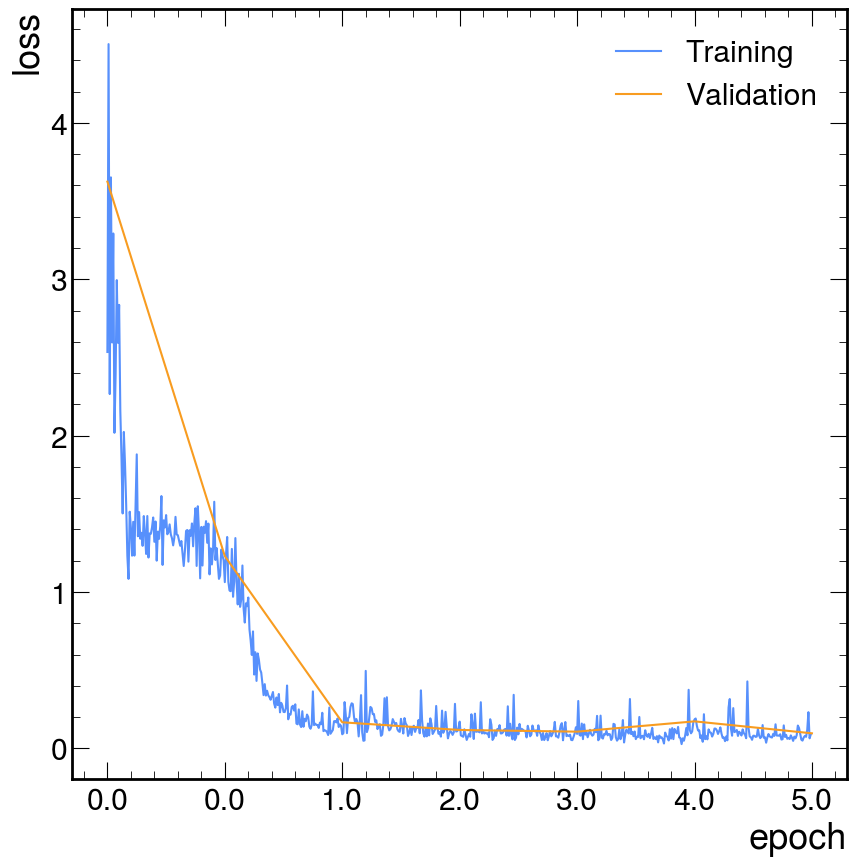

In [11]:

plt.plot(out_df[out_df['train_loss'].notna()]['step'], out_df['train_loss'].dropna(), label='Training')
plt.plot(out_df[out_df['val_loss'].notna()]['step'], out_df['val_loss'].dropna(), label='Validation')
plt.xticks(ticks=out_df[out_df['val_loss'].notna()]['step'], labels=out_df[out_df['val_loss'].notna()]['epoch'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

(0.001, 30.0)

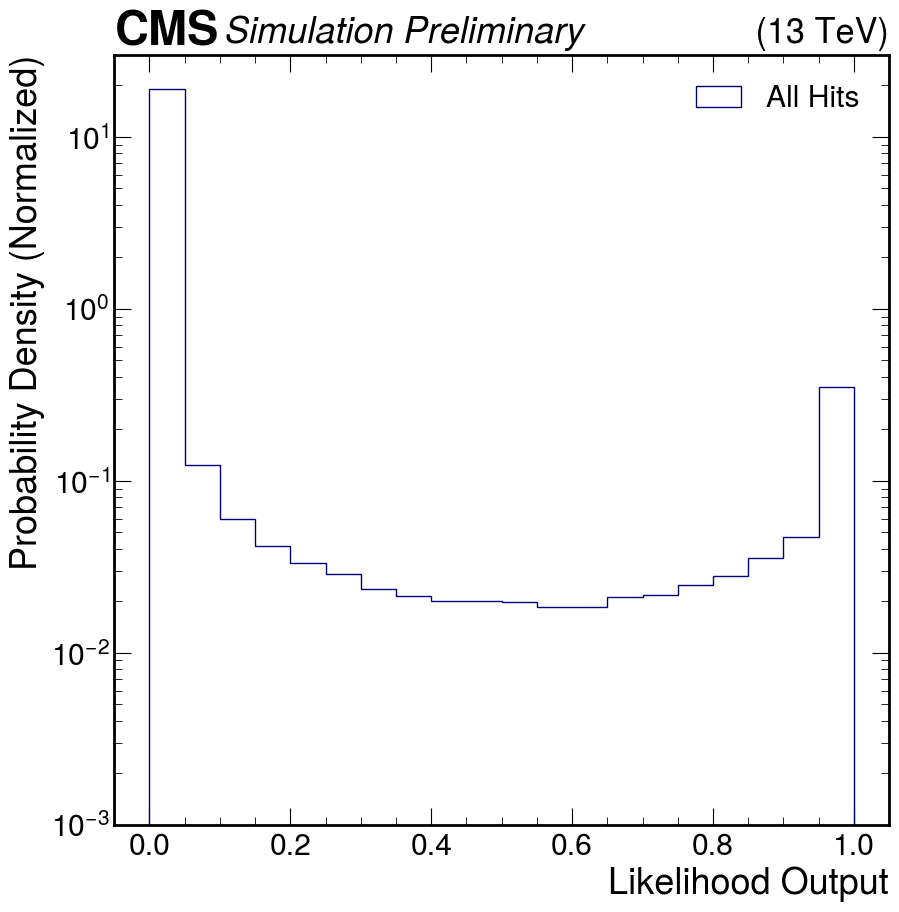

In [12]:
# Now, you have two arrays of data.
# Likelihood contains the model's output probability for each hit
bins = np.linspace(0, 1, 21)
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(
        likelihood, 
        bins=bins, 
        density=True, 
        label='All Hits',
        histtype='step',
        color='navy'
    )
plt.yscale('log')
plt.legend()
plt.xlabel('Likelihood Output')
plt.ylabel('Probability Density (Normalized)')
mh.cms.label(loc=0, label="Preliminary", data=False) 

plt.ylim(1e-3, 3e1) 



/opt/homebrew/Caskroom/miniconda/base/envs/ME0/lib/python3.11/site-packages/matplotlib/axes/_axes.py:7132: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


(0.001, 30.0)

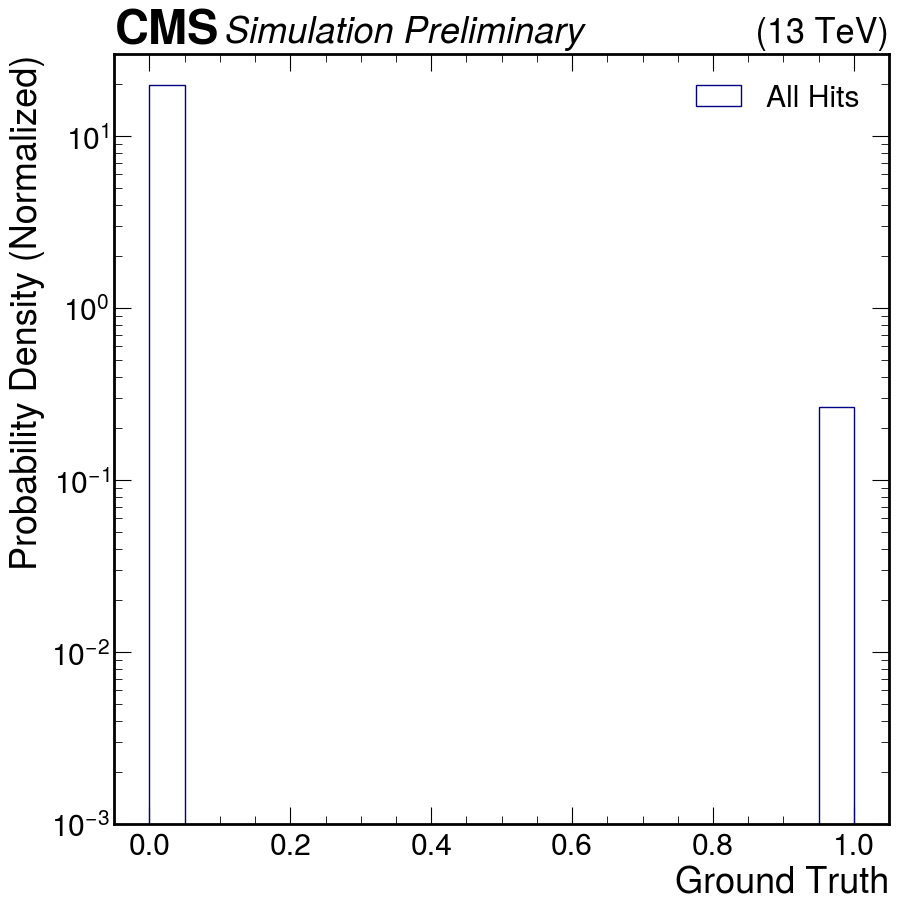

In [13]:
# Groundtruth contains the mc truth of if the hit is a muon or not. 
bins = np.linspace(0, 1, 21)
fig, ax = plt.subplots(figsize=(10, 10))
plt.hist(
        groundtruth, 
        bins=bins, 
        density=True, 
        label='All Hits',
        histtype='step',
        color='navy'
    )
plt.yscale('log')
plt.legend()
plt.xlabel('Ground Truth')
plt.ylabel('Probability Density (Normalized)')
mh.cms.label(loc=0, label="Preliminary", data=False) 

plt.ylim(1e-3, 3e1) 



In [14]:
# And here is a simple bit of code to compute the tpr/fpr for a certain cut value
# 
def compute_tpr_fpr(groundtruth, likelihood, cutoff):
    mask = groundtruth == 1
    n_muons = mask.sum()
    n_non_muons = (1-mask).sum()

    tp = (likelihood[groundtruth] >= cutoff).sum()
    tpr = tp/n_muons

    fp = (likelihood[~groundtruth] >= cutoff).sum()
    fpr = fp / n_non_muons
    return float(tpr), float(fpr)
# Compute the true positive rate and false positve rate for a cutoff of .5 in the likelihood
compute_tpr_fpr(groundtruth, likelihood, .5)

(0.9861904355979882, 0.016257571663791572)

In [15]:
# Compute tpr and fpr for various cutoffs
cutoffs = np.linspace(0, 1, 1000)
tprs = []
fprs = []
for cutoff in cutoffs:
    tpr, fpr = compute_tpr_fpr(groundtruth, likelihood, cutoff)
    tprs.append(tpr)
    fprs.append(fpr)

tprs = np.array(tprs)
fprs = np.array(fprs)

In [16]:
#This function allows you to compute the fpr at a target tpr
def fpr_at_tpr(target_tpr, tprs, fprs, cutoffs):
    # Ensure tprs are sorted increasingly for interpolation
    sort_idx = np.argsort(tprs)
    tprs_sorted = tprs[sort_idx]
    fprs_sorted = fprs[sort_idx]
    cutoffs_sorted = cutoffs[sort_idx]

    # Interpolate FPR and Cutoff
    interpolated_fpr = np.interp(target_tpr, tprs_sorted, fprs_sorted)
    interpolated_cutoff = np.interp(target_tpr, tprs_sorted, cutoffs_sorted)

    return float(interpolated_cutoff), float(interpolated_fpr)

In [17]:
fpr_at_tpr(.9, tprs, fprs, cutoffs), fpr_at_tpr(.95, tprs, fprs, cutoffs), fpr_at_tpr(.995, tprs, fprs, cutoffs)

((0.9678518518518519, 0.004213967193883088),
 (0.9059976643309978, 0.007086419154375339),
 (0.08496996996996994, 0.030103110877100613))

In [18]:
# From here, you can produce ROC curves, other histograms.